In [43]:
# import libraries
import types
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [44]:
# user defined function for transforming a variable to stationarity
def transform(column, transformation):

    # 1 => No transformation
    if transformation == 1:
        pass
    # 2 => First difference
    elif transformation == 2:
        column = column.diff()
    # 3 => Second difference
    elif transformation == 3:
        column = column.diff().diff()
    # 4 => Log
    elif transformation == 4:
        column = np.log(column)
    # 5 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    elif transformation == 5:
        column = np.log(column).diff() * 100# * mult
    # 6 => Log second difference, multiplied by 100
    elif transformation == 6:
        column = np.log(column).diff().diff() * 100# * mult
    # 7 => Exact percent change, multiplied by 100
    elif transformation == 7:
        column = ((column / column.shift(1)) - 1.0) * 100
    # 8 => Log third difference, multiplied by 100
    elif transformation == 8:
        column = np.log(column).diff().diff().diff() * 100
        
    return column

In [45]:
# user defined function for remove outliers
def remove_outliers(dta):
    # Compute the mean and interquartile range
    mean = dta.mean()
    iqr = dta.quantile([0.25, 0.75]).diff().T.iloc[:, 1]
    
    # Replace entries that are more than 1.5 times the IQR
    # away from the mean with NaN (denotes a missing entry)
    mask = np.abs(dta) > mean + 1.5 * iqr
    treated = dta.copy()
    treated[mask] = np.nan

    return treated

In [46]:
# read the monthly frequency predictor variables for Mongolia
df = pd.read_excel("dfm.xlsx")

# extract the transformation codes for each variable
trans_monthly = list(df.iloc[0])[1:]

# exclude the transformation codes for further analysis
df = df.iloc[1: , :]

# re-index the df by the date column
df.index = df['date'].dt.to_period('M')
df = df.drop(columns = 'date')

In [47]:
# read the quarterly frequency predictor variables for Mongolia
df_quar = pd.read_excel('dfm_quarterly.xlsx')

# extract the transformation codes for each variable
trans_quart = list(df_quar.iloc[0])[1:]

# exclude the transformation codes for further analysis
df_quar = df_quar.iloc[1: , :]

# re-index the df by the date column
df_quar.index = df_quar['date'].dt.to_period('Q')
df_quar = df_quar.drop(columns = 'date')

In [48]:
# create the new df to store interpolated quarterly variables
df_quar_month = pd.DataFrame()

for column in df_quar.columns:
    
    # interpolate quarterly to monthly
    df_quar_month[column] = df_quar[column].resample('M').interpolate()
    
    # append the newly interpolated variables into the larger df
    df[column] = df_quar_month[column]

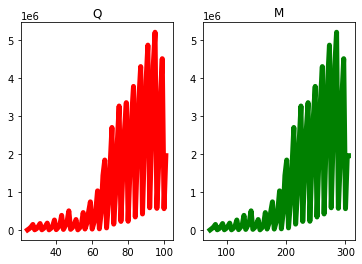

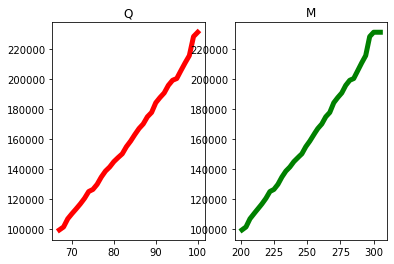

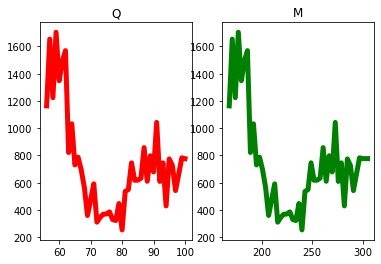

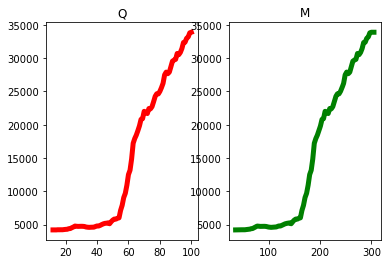

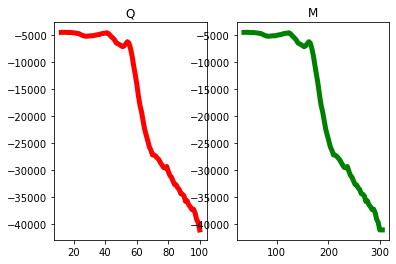

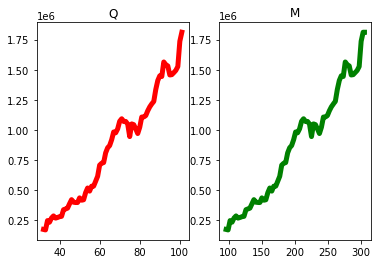

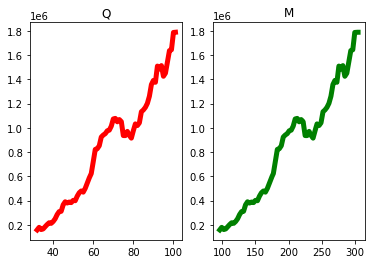

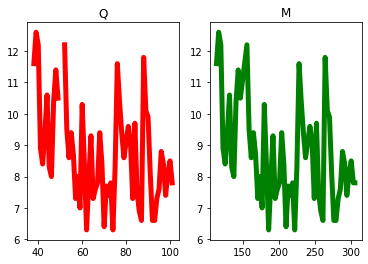

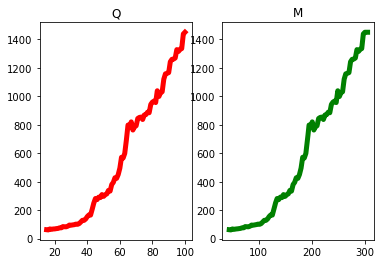

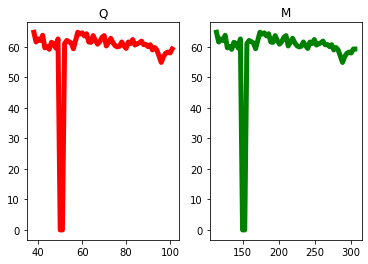

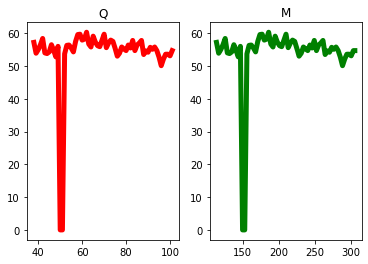

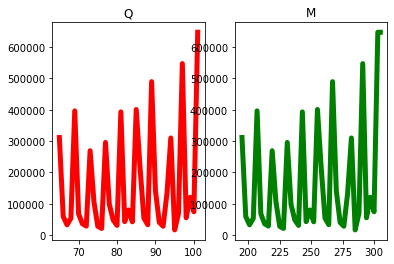

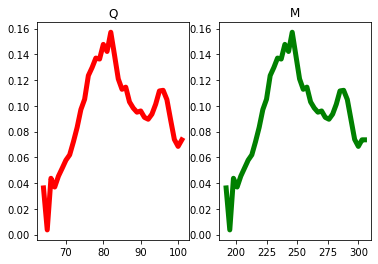

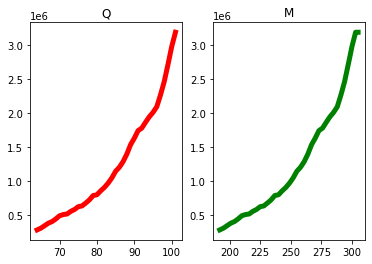

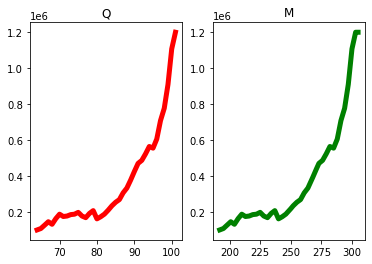

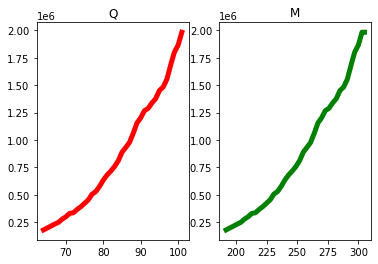

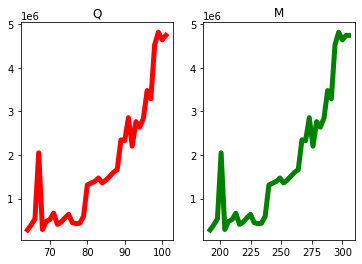

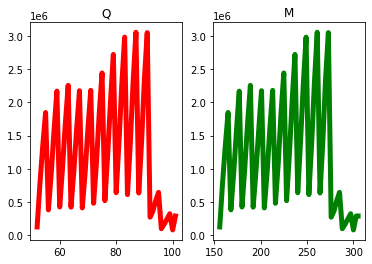

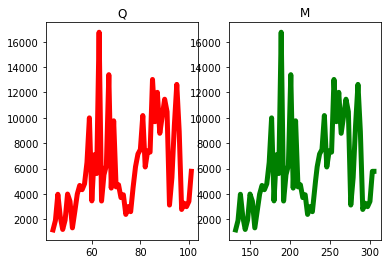

In [49]:
# visual check of original quarterly variable and its monthly interpolation
for column in df_quar_month.columns:
    
    plt.subplot(1, 2, 1) # row 1, column 2, count 1
    plt.plot(range(len(df_quar[column])), df_quar[column], 'r', linewidth = 5)
    plt.title('Q')
 
    plt.subplot(1, 2, 2) # row 1, column 2, count 2
    plt.plot(range(len(df_quar_month[column])), df_quar_month[column], 'g', linewidth = 5)
    plt.title('M')

    plt.show()

In [50]:
# combine the transformation codes for monthly and quarterly interpolated variables
transformations = trans_monthly + trans_quart

In [51]:
# Augmented Dickey Fuller test for all the predictors
counter = 0
for column in df.columns:
    print(counter, column, adfuller(df[column].dropna())[1])
    counter += 1

0 m2 1.0
1 cbank_net_for_assets 0.16255383094757153
2 dom_loan_rate 0.02270281697587153
3 for_loan_rate 0.06670896682255371
4 export 0.994365639261521
5 import 0.7762465810606138
6 govt_bud_def 0.01651407858235372
7 stock_market_cap 0.9930989404475306
8 top_20 0.6565782772961583
9 usd_mnt 0.9962189973463513
10 cny_mnt 0.9969578720140326
11 cpi_yoy 0.0075285159250777
12 ppi_2015 0.9649671165674714
13 avg_temp 0.045174214567009166
14 nitrate_dio 0.6060632875121988
15 disasters 0.09837217568449225
16 china_cpi_yoy 0.009011441368376475
17 brent 0.19060276489391836
18 copper 0.3725065265868548
19 gold 0.6191115251383595
20 ca_def 0.1419946095121219
21 electricity_prod 1.0
22 thermal_prod 1.0
23 water_prod 0.019867952120426458
24 coal_prod 0.46418435370788796
25 crude_oil_prod 0.6981613239403763
26 copper_conc_prod 0.004294930423683257
27 gold_prod 0.5089176352369402
28 iron_prod 0.8790466784472131
29 iron_conc_prod 0.2667337132391955
30 reer 0.09509801755381359
31 neer 0.8961099024640862
32

In [52]:
# Augmented Dickey Fuller test for all the predictors after transformation
counter = 0
for column in df.columns:
    transformed_col = transform(df[column], transformations[counter]).replace([np.inf], np.nan).dropna()
    print(counter, column, adfuller(transformed_col)[1] < 0.05)
    counter += 1

0 m2 True
1 cbank_net_for_assets True
2 dom_loan_rate True
3 for_loan_rate True
4 export True
5 import False
6 govt_bud_def True
7 stock_market_cap True
8 top_20 True
9 usd_mnt True
10 cny_mnt True
11 cpi_yoy True
12 ppi_2015 True
13 avg_temp True
14 nitrate_dio True
15 disasters True
16 china_cpi_yoy True
17 brent True
18 copper True
19 gold True
20 ca_def True
21 electricity_prod True
22 thermal_prod True
23 water_prod True
24 coal_prod True
25 crude_oil_prod True
26 copper_conc_prod True
27 gold_prod True
28 iron_prod True
29 iron_conc_prod True
30 reer True
31 neer True
32 com_bank_cbank bill_to_assets True
33 com_bank_foreign_assets_to_assets True
34 com_bank_claims_to_assets True
35 com_bank_public_claim_to_assets True
36 com_bank_private_claim_to_assets True
37 com_bank_individual_claim_to_assets True
38 total_assets True
39 com_bank_demand_depo_liabilities True
40 com_bank_foregn_liab_to_liabalities True
41 com_bank_credit_from_cbank_to_liabalities True
42 total_liabilities Tru

In [53]:
# after checking if the transformations results in stationarity
# create a new df to store the transformed data
df1 = df.copy()
counter = 0
for column in df1.columns:
    df1[column] = transform(df[column], transformations[counter]).replace([np.inf], np.nan)
    counter += 1

In [54]:
# read GDP data for Mongolia
gdp = pd.read_excel('gdp.xlsx')

# re-index the gdp by the date column
gdp.index = gdp['date'].dt.to_period('Q')
gdp = gdp.drop(columns = 'date')

# remove outliers
gdp = remove_outliers(gdp)

In [55]:
# full sample fit
gdp_train = gdp.loc[:'2022Q2']
df1_train = df1.loc[:'2022-07']

In [56]:
# no factor loadings and groupings at this moment
# the model has only 1 global group at this moment
# standardize the predictors to have mean 0 and variance 1
mod_1 = sm.tsa.DynamicFactorMQ(df1_train, endog_quarterly = gdp_train, standardize = True)

# fit the model by Expectation Maximization algorithm
res1 = mod_1.fit_em()

# print the summary of the fit
print(res1.summary())

C:\Users\jants\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               Dynamic Factor Results                              
Dep. Variable:           "m2", and 91 more   No. Observations:                  307
Model:                Dynamic Factor Model   Log Likelihood              -23575.235
                   + 1 factors in 1 blocks   AIC                          47706.470
                   + Mixed frequency (M/Q)   BIC                          48742.534
                     + AR(1) idiosyncratic   HQIC                         48120.782
Date:                     Sun, 09 Oct 2022   EM Iterations                      177
Time:                             15:15:46                                         
Sample:                         01-31-1997                                         
                              - 07-31-2022                                         
Covariance Type:              Not computed                                         
                          Observation equation:                          
  

<AxesSubplot:xlabel='date'>

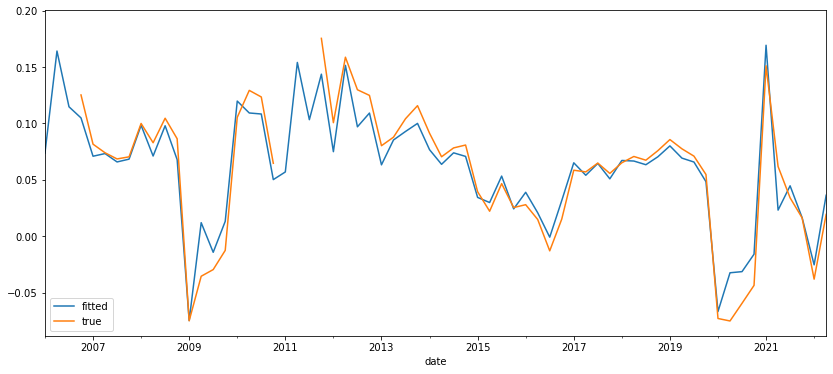

In [57]:
# get fitted values 
fitted_values = res1.predict()

# create df with fitted GDP and true GDP
temp_df = pd.DataFrame(data = {'fitted': fitted_values.gdp.resample('Q').mean().shift(-1).loc['2006Q1':'2022Q2'],\
                              'true': gdp.gdp.loc[:'2022Q2']})

# plot the true and fitted GDP growth
fig, ax = plt.subplots(figsize=(14, 6))
temp_df.plot(ax = ax)

<AxesSubplot:>

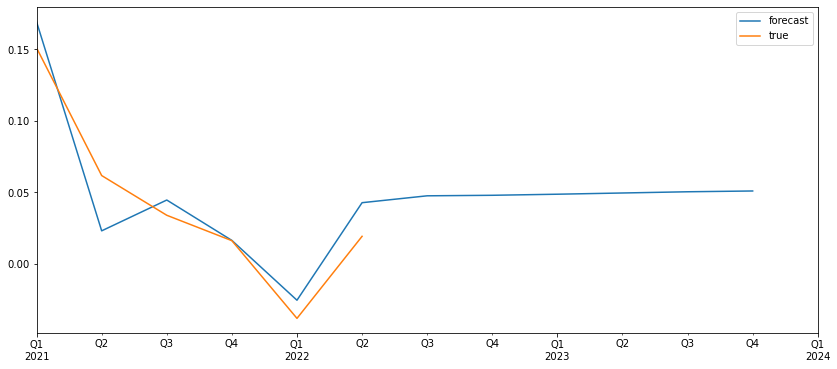

In [58]:
# generate predications for GDP growth from 2021Q1 to 2024Q1
pred = res1.get_prediction(start = '2021Q1', end = '2024Q1')

# create df with predicted GDP and true GDP
temp_df2 = pd.DataFrame(data = {'forecast': pred.predicted_mean.gdp.resample('Q').mean().shift(-1).loc['2021Q1':],\
                              'true': gdp.gdp.loc['2021Q1':'2022Q4']})

# plot the true and predicted GDP growth
fig, ax = plt.subplots(figsize=(14, 6))
temp_df2.plot(ax = ax)

In [59]:
# create a benchmark model of AR(1)
ar1 = AutoReg(gdp.gdp.dropna(), 1).fit()
print(ar1.summary())

                            AutoReg Model Results                             
Dep. Variable:                    gdp   No. Observations:                   62
Model:                     AutoReg(1)   Log Likelihood                 102.433
Method:               Conditional MLE   S.D. of innovations              0.045
Date:                Sun, 09 Oct 2022   AIC                           -198.867
Time:                        15:15:47   BIC                           -192.534
Sample:                    12-31-2006   HQIC                          -196.385
                         - 06-30-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0203      0.008      2.469      0.014       0.004       0.036
gdp.L1         0.6278      0.094      6.656      0.000       0.443       0.813
                                    Roots           

<AxesSubplot:xlabel='date'>

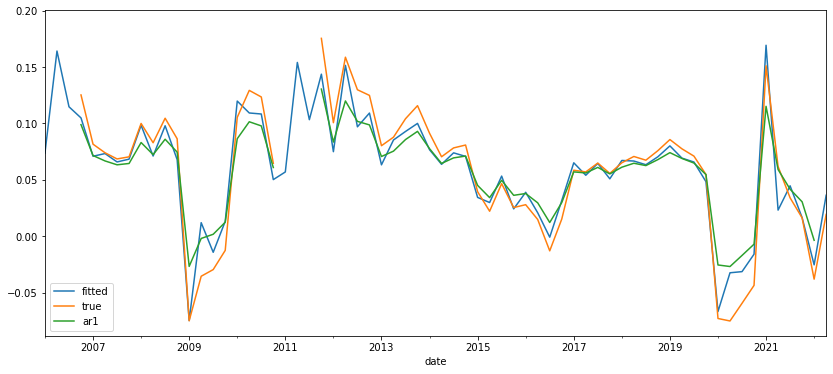

In [60]:
# create df with DFM fit, AR(1) fit, and true GDP
temp_df3 = pd.DataFrame(data = {'fitted': fitted_values.gdp.resample('Q').mean().shift(-1).loc['2006Q1':'2022Q2'],\
                              'true': gdp.gdp.loc[:'2022Q2'],\
                              'ar1':ar1.predict().shift(-1)})

# plot the true and predicted GDP growth
fig, ax = plt.subplots(figsize=(14, 6))
temp_df3.plot(ax = ax)

In [61]:
# RMSE for DFM fitted values and true GDP
print('DFM RMSE:', np.sqrt(np.sum((temp_df3.true - temp_df3.fitted) ** 2)))

# RMSE for AR(1) fitted values and true GDP
print('AR(1) RMSE:', np.sqrt(np.sum((temp_df3.true - temp_df3.ar1) ** 2)))

DFM RMSE: 0.13080721832721698
AR(1) RMSE: 0.1793972103714939
